<a href="https://colab.research.google.com/github/charlesm93/nested-rhat/blob/main/Nested_R_hat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Between chain and superchain variance

This file is an updated version of an original notebook released by Google Research (https://github.com/google-research/google-research/tree/master/nested_rhat, Copyright 2021 Google LLC.)

Revision to this notebook were made by Charles C. Margossian (Copyright 2022 Charles C. Margossian)

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install --upgrade jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.7 MB/s 
  Created wheel for jax: filename=jax-0.3.16-py3-none-any.whl size=1197715 sha256=08bfe468f90c32967dd7bd35f7a25f6134220666432e14fcbf809204b859c5a3
  Stored in directory: /root/.cache/pip/wheels/b9/0d/a2/2091279bf29b90a2211a271f6f006ef13a656211a9e69ba1e3
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14


In [ ]:
# Pavel's code to get fun_mc running 
!rm -Rf probability
!rm -Rf fun_mc
!rm -Rf inference_gym
!git clone https://github.com/tensorflow/probability.git
!mv probability/spinoffs/fun_mc/fun_mc .
!mv probability/spinoffs/inference_gym/inference_gym .
!pip install tf-nightly tfp-nightly jax jaxlib

Cloning into 'probability'...
remote: Enumerating objects: 96027, done.
remote: Counting objects: 100% (1030/1030), done.
remote: Compressing objects: 100% (453/453), done.
remote: Total 96027 (delta 661), reused 876 (delta 573), pack-reused 94997
Receiving objects: 100% (96027/96027), 133.99 MiB | 21.23 MiB/s, done.
Resolving deltas: 100% (77842/77842), done.
Checking out files: 100% (1385/1385), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 582.2 MB 20 kB/s 
     |████████████████████████████████| 6.6 MB 25.9 MB/s 
     |████████████████████████████████| 1.7 MB 55.3 MB/s 
     |████████████████████████████████| 5.9 MB 41.2 MB/s 
     |████████████████████████████████| 439 kB 72.5 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


In [ ]:
!pip install immutabledict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# from colabtools import adhoc_import  (only needed inside Google)
from contextlib import ExitStack

from fun_mc import using_jax as fun_mc

# ADHOC = True
# CLIENT = 'fig-export-fig_tree-change-451-3e0a679e9746'

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

In [ ]:
from google.colab import files  # use this download saved plots

# Variance analysis

ESS mean + std: 100.14388 1.456046
pooled ESS mean + std: 301.09787 665.4375
nested ESS mean + std: 767688.25 1682722.5
nested normalized ESS mean + std: 299.87823 657.3135

rhat - 1 mean + std: 0.009987743 0.00014515023
pooled rhat - 1 mean + std: 0.009639146 0.008081206
nested rhat - 1 mean + std: 3.7191692e-06 3.0890765e-06
nested normalized rhat - 1 mean + std: 0.009521073 0.007908035


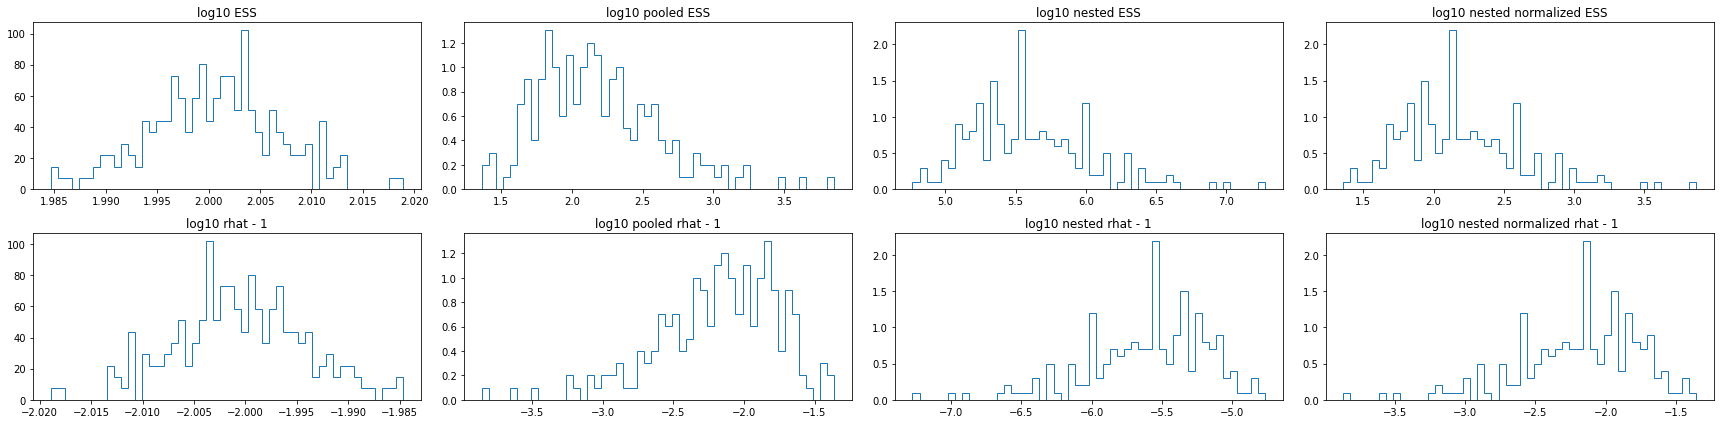

In [ ]:
n_chains = 10240
n_super_chains = 4
n_steps = 100
n_sub_chains = n_chains // n_super_chains

# ESS by looking at raw chains
ess_vals = []
# ESS computed by looking at super chains
pooled_ess_vals = []
# Like pooled ESS, but we account for the number of sub chains used
nested_ess_vals = []

for seed in jax.random.split(jax.random.PRNGKey(0), 200):
  chain = jax.random.normal(seed, [n_steps, n_chains])
  pooled_chain = chain.reshape([n_steps, n_sub_chains, n_super_chains])

  between = chain.mean(0).var(0, ddof=1)
  overall = chain.var((0, 1), ddof=1)
  ess_vals.append(overall / between)

  super_chain = pooled_chain.mean(1)
  pooled_between = super_chain.mean(0).var(0, ddof=1)
  pooled_overall = super_chain.var((0, 1), ddof=1)
  pooled_ess_vals.append(pooled_overall / pooled_between)

  if True:
    nested_between = pooled_chain.mean((0, 1)).var(0, ddof=1)
    nested_overall = pooled_chain.var((0, 1, 2), ddof=1)
    nested_ess_vals.append((nested_overall / nested_between))
  else:
    # Calculation from Charles's notebook.
    mean_chain = pooled_chain.mean(0)
    mean_super_chain = pooled_chain.mean((0, 1))
    variance_chain = pooled_chain.var(0, ddof=1)
    variance_nested_chain = mean_chain.var(0, ddof=1) + variance_chain.mean(0)

    within_var = variance_nested_chain.mean(0)
    between_var = mean_super_chain.var(0, ddof=1)

    nested_ess_vals.append((1 + within_var / between_var))

ess_vals = jnp.array(ess_vals)
pooled_ess_vals = jnp.array(pooled_ess_vals)
nested_ess_vals = jnp.array(nested_ess_vals)
# We can also normalize the nested ESS values to take into account that super
# chains are larger than regular chains. This interprets the pooling as an
# ostensibly denoised ESS estimator.
nested_normalized_ess_vals = nested_ess_vals / n_sub_chains

# These are actually rhat - 1
rhat_vals = 1 / ess_vals
pooled_rhat_vals = 1 / pooled_ess_vals
nested_rhat_vals = 1 / nested_ess_vals
# It's not clear what the meaning of this is.
nested_normalized_rhat_vals = 1 / nested_normalized_ess_vals

# Expected per-chain ESS is n_steps
print('ESS mean + std:', ess_vals.mean(), ess_vals.std())
print('pooled ESS mean + std:', pooled_ess_vals.mean(), pooled_ess_vals.std())
print('nested ESS mean + std:', nested_ess_vals.mean(), nested_ess_vals.std())
print('nested normalized ESS mean + std:', nested_normalized_ess_vals.mean(), nested_normalized_ess_vals.std())
print()
print('rhat - 1 mean + std:', rhat_vals.mean(), rhat_vals.std())
print('pooled rhat - 1 mean + std:', pooled_rhat_vals.mean(), pooled_rhat_vals.std())
print('nested rhat - 1 mean + std:', nested_rhat_vals.mean(), nested_rhat_vals.std())
print('nested normalized rhat - 1 mean + std:', nested_normalized_rhat_vals.mean(), nested_normalized_rhat_vals.std())

fig = plt.figure(figsize=(24, 6))
plt.subplot(2, 4, 1)
plt.title('log10 ESS')
plt.hist(jnp.log10(ess_vals), histtype='step', density=True, bins=50)

plt.subplot(2, 4, 2)
plt.title('log10 pooled ESS')
plt.hist(jnp.log10(pooled_ess_vals), histtype='step', density=True, bins=50)

plt.subplot(2, 4, 3)
plt.title('log10 nested ESS')
plt.hist(jnp.log10(nested_ess_vals), histtype='step', density=True, bins=50);

plt.subplot(2, 4, 4)
plt.title('log10 nested normalized ESS')
plt.hist(jnp.log10(nested_normalized_ess_vals), histtype='step', density=True, bins=50);

plt.subplot(2, 4, 5)
plt.title('log10 rhat - 1')
plt.hist(jnp.log10(rhat_vals), histtype='step', density=True, bins=50)

plt.subplot(2, 4, 6)
plt.title('log10 pooled rhat - 1')
plt.hist(jnp.log10(pooled_rhat_vals), histtype='step', density=True, bins=50)

plt.subplot(2, 4, 7)
plt.title('log10 nested rhat - 1')
plt.hist(jnp.log10(nested_rhat_vals), histtype='step', density=True, bins=50);

plt.subplot(2, 4, 8)
plt.title('log10 nested normalized rhat - 1')
plt.hist(jnp.log10(nested_normalized_rhat_vals), histtype='step', density=True, bins=50);

fig.tight_layout()

# MCMC test

## Unimodal Gaussian target

First run the test with a unimodal target: a standard Gaussian.

In [ ]:
dist = tfd.Normal(0., 1.)
n_chains = 16384  # 10240
n_super_chains = 128  # 8
n_steps = 100
num_samples = 10000
n_sub_chains = n_chains // n_super_chains

def target_log_prob_fn(x):
  return dist.log_prob(x), ()


def kernel(hmc_state, seed):
  hmc_seed, seed = jax.random.split(seed)
  hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
      hmc_state,
      target_log_prob_fn=target_log_prob_fn,
      step_size=0.5,
      num_integrator_steps=1,
      seed=hmc_seed)
  return (hmc_state, seed), (hmc_state.state, hmc_extra.is_accepted)

# Draw sample from the stationary distribution
init_x = dist.sample([n_chains], seed=jax.random.PRNGKey(0))

_, (chain, is_accepted) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x,
    target_log_prob_fn), jax.random.PRNGKey(0)), kernel, num_samples)

init_x2 = dist.sample([n_super_chains], seed=jax.random.PRNGKey(3))
init_x2 = jnp.repeat(init_x2, n_sub_chains)
#init_x2 = dist.sample([num_chains], seed=jax.random.PRNGKey(3))
init_x2 = init_x2.reshape([n_super_chains, n_sub_chains])

_, (chain2, is_accepted2) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x2,
    target_log_prob_fn), jax.random.PRNGKey(3)), kernel, num_samples)

chain = jnp.concatenate([init_x[jnp.newaxis], chain], 0)
chain2 = jnp.concatenate([init_x2[jnp.newaxis], chain2], 0)
chain3 = chain.reshape(num_samples + 1, -1, n_sub_chains)

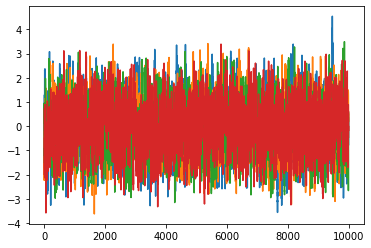

In [ ]:
plt.plot(chain[:, :4])
plt.show()

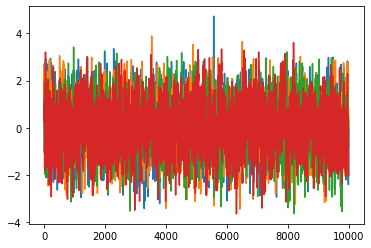

In [ ]:
plt.plot(chain2[:, 0, :4])
plt.show()

In [ ]:
chain2[0].mean(-1).var(0), chain[0].var(0)

(DeviceArray(0.9480518, dtype=float32), DeviceArray(1.011666, dtype=float32))

In [ ]:
between_reg = (jnp.cumsum(chain, 0) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis]).var(1)
#between_reg = (jnp.cumsum(chain2, 0) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis, jnp.newaxis]).var((1, 2))
super_chain = chain2.mean(-1)
between_nested = (jnp.cumsum(super_chain, 0) / jnp.arange(1, super_chain.shape[0] + 1)[:, jnp.newaxis]).var(1)

super_chain_naive = chain3.mean(-1)
between_nested_naive = (jnp.cumsum(super_chain_naive, 0) / jnp.arange(1, super_chain_naive.shape[0] + 1)[:, jnp.newaxis]).var(1)


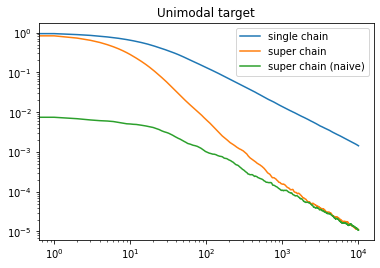

In [ ]:
plt.title('Unimodal target')
plt.plot(between_reg, label='single chain')
plt.plot(between_nested, label='super chain')
# plt.plot(between_reg / n_sub_chains, label='single chain / $N$')
plt.plot(between_nested_naive, label = 'super chain (naive)')
# plt.axhline(1e-2, ls='--', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('chain length')
plt.legend()

In [ ]:
# Store to create plots later
between_reg_uni = between_reg
between_nested_uni = between_nested
between_nested_naive_uni = between_nested_naive

In [ ]:
between_reg2 = between_reg
between_nested2 = between_nested
n_sub_chains2 = n_sub_chains

In [ ]:
print(between_reg[0])
print(between_nested[0] / between_reg[0])

1.011666
0.9371193


128
128


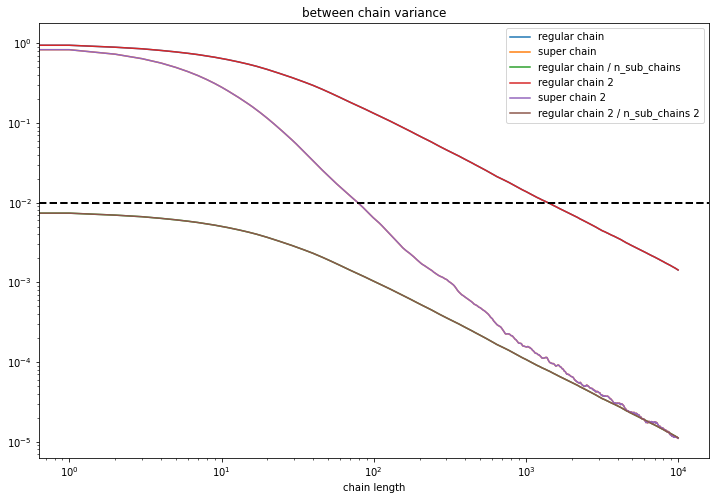

In [ ]:
print(n_sub_chains)
print(n_sub_chains2)
plt.figure(figsize=(12, 8))
plt.title('between chain variance')

plt.plot(between_reg, label='regular chain')
plt.plot(between_nested, label='super chain')
plt.plot(between_reg / n_sub_chains, label='regular chain / n_sub_chains')

plt.plot(between_reg2, label='regular chain 2')
plt.plot(between_nested2, label='super chain 2')
plt.plot(between_reg2 / n_sub_chains2, label='regular chain 2 / n_sub_chains 2')

plt.axhline(1e-2, ls='--', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('chain length')
plt.legend()

## Bimodal target
Now target a bimodal distribution, meaning the chains will not mix. We'll use a mixture of two Gaussians, $0.3 N(-10, 1) + 0.7 N(10, 1)$.

In [ ]:
n_chains = 16384 # 4096
n_super_chains = 128  # 32
n_sub_chains = n_chains // n_super_chains
num_samples = 10000

dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.3, 0.7]), 
    components_distribution=tfd.Normal(
      loc=[-5, 5],
      scale=[1, 1]))

def target_log_prob_fn(x):
  return dist.log_prob(x), ()


def kernel(hmc_state, seed):
  hmc_seed, seed = jax.random.split(seed)
  hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
      hmc_state,
      target_log_prob_fn=target_log_prob_fn,
      step_size= 0.5,
      num_integrator_steps=1,
      seed=hmc_seed)
  return (hmc_state, seed), (hmc_state.state, hmc_extra.is_accepted)

# Draw initialization from the stationary distribution
init_x = 4 * dist.sample([n_chains], seed=jax.random.PRNGKey(1))

_, (chain, is_accepted) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x,
    target_log_prob_fn), jax.random.PRNGKey(0)), kernel, num_samples)

# Now enforce all chains within a superchain to start at the same point.
init_x2 = 4 * dist.sample([n_super_chains], seed=jax.random.PRNGKey(5))
init_x2 = jnp.repeat(init_x2, n_sub_chains)
init_x2 = init_x2.reshape([n_super_chains, n_sub_chains])

_, (chain2, is_accepted2) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x2,
    target_log_prob_fn), jax.random.PRNGKey(3)), kernel, num_samples)

chain = jnp.concatenate([init_x[jnp.newaxis], chain], 0)
chain2 = jnp.concatenate([init_x2[jnp.newaxis], chain2], 0)
chain3 = chain.reshape(num_samples + 1, -1, n_sub_chains)

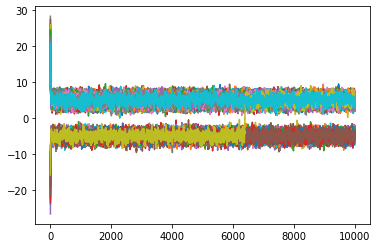

In [ ]:
plt.plot(chain[:, :100])
plt.show()

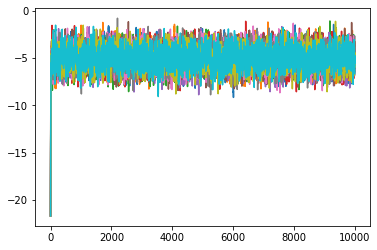

In [ ]:
# Only plotting chains within a super-chain, so they appear to have converged.
# Get different results when comparing between superchains.
plt.plot(chain2[:, 10, :10])
plt.show()

Text(0.5, 0, 'chain length')

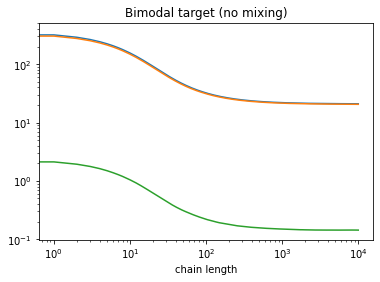

In [ ]:
between_reg = (jnp.cumsum(chain, 0) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis]).var(1)
#between_reg = (jnp.cumsum(chain2, 0) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis, jnp.newaxis]).var((1, 2))
super_chain = chain2.mean(-1)
between_nested = (jnp.cumsum(super_chain, 0) / jnp.arange(1, super_chain.shape[0] + 1)[:, jnp.newaxis]).var(1)

super_chain_naive = chain3.mean(-1)
between_nested_naive = (jnp.cumsum(super_chain_naive, 0) / jnp.arange(1, super_chain_naive.shape[0] + 1)[:, jnp.newaxis]).var(1)

plt.title('Bimodal target (no mixing)')
plt.plot(between_reg, label='single chain')
plt.plot(between_nested, label='super chain')
plt.plot(between_nested_naive, label = 'super chain (naive)')
# plt.plot(between_reg / n_sub_chains, label='single chain / $N$')
# plt.axhline(21, ls = '-', color = 'black')
# plt.axhline(1e-2 * 21, ls='--', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('chain length')
# plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


Text(0.5, 0.025, 'Chain Length')

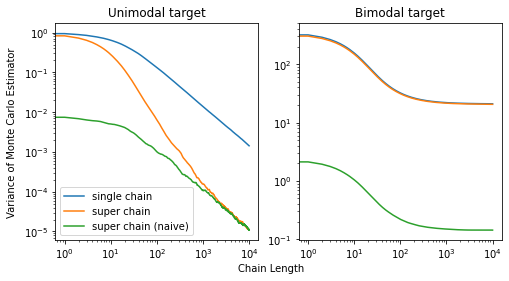

In [ ]:
fig, ax = plt.subplots(1, 2, sharey = False, sharex = True,
                   figsize=(8, 4))
ax[0].plot(between_reg_uni, label='single chain')
ax[0].plot(between_nested_uni, label='super chain')
ax[0].plot(between_nested_naive_uni, label = 'super chain (naive)')
ax[0].legend(loc = "bottom left")
ax[0].set_title("Unimodal target")

ax[0].set_yscale('log')

ax[1].plot(between_reg, label='single chain')
ax[1].plot(between_nested, label='super chain')
ax[1].plot(between_nested_naive, label = 'super chain (naive)')
ax[1].set_title("Bimodal target")

ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_xlabel('Chain Length')

fig.text(0.05, 0.5, 'Variance of Monte Carlo Estimator', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.025, "Chain Length", ha="center", va="center")

In [ ]:
fig.savefig("MC_variance.pdf")
files.download("MC_variance.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>